In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from  tensorflow.keras.utils import image_dataset_from_directory
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9649806939405550337
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801405440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5157133944653192903
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
img_width, img_height = 256, 256
# directory = '/content/gdrive/My Drive/Rohan Work/automation_dataset_V.1.2'
directory = 'automation_dataset_V.1.2'

In [5]:
dataset = image_dataset_from_directory(directory)

Found 5017 files belonging to 5 classes.


In [6]:
data_dir = pathlib.Path(directory)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5017


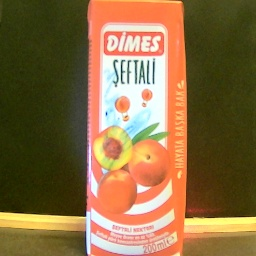

In [7]:
sample = list(data_dir.glob('blue/*'))
PIL.Image.open(str(sample[0]))

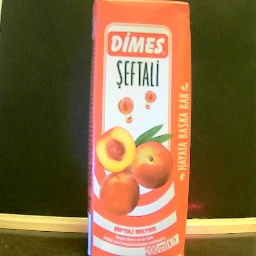

In [8]:
sample = list(data_dir.glob('flawless/*'))
PIL.Image.open(str(sample[0]))

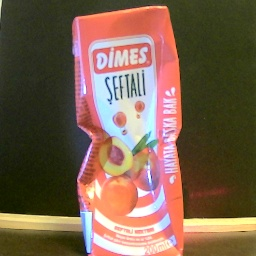

In [9]:
sample = list(data_dir.glob('pressed/*'))
PIL.Image.open(str(sample[0]))

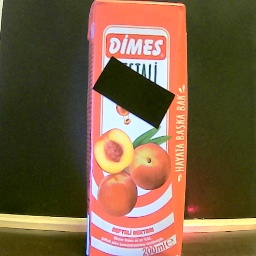

In [10]:
sample = list(data_dir.glob('stained/*'))
PIL.Image.open(str(sample[0]))

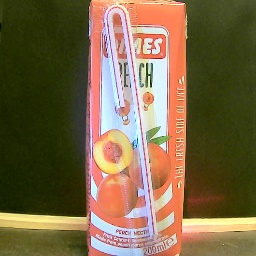

In [11]:
sample = list(data_dir.glob('straw/*'))
PIL.Image.open(str(sample[0]))

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  seed=101,
  image_size=(img_height, img_width),
  batch_size=256)


Found 5017 files belonging to 5 classes.
Using 3512 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  seed=101,
  image_size=(img_height, img_width),
  batch_size=256)

Found 5017 files belonging to 5 classes.
Using 1505 files for validation.


In [14]:
def get_images_from_dataset(ds):
    ds_unbatched = ds.unbatch()
    images = list(ds_unbatched.map(lambda x, y: x))
    labels = list(ds_unbatched.map(lambda x, y: y))
    return images, labels

In [15]:
num_validation_elements = val_ds.cardinality().numpy()
print(num_validation_elements)
validation_size = int(0.66 * num_validation_elements) + 1
print(validation_size)
val_ds = val_ds.take(validation_size)
test_ds = val_ds.skip(validation_size)

6
4


In [16]:
test_ds = val_ds.skip(validation_size-2)
print(type(test_ds))
test_ds_unbatched = get_images_from_dataset(test_ds)
# len(test_ds[1])

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [17]:
val_ds_unbatched = get_images_from_dataset(val_ds)
len(val_ds_unbatched[1])

1024

(array([203.,   0., 177.,   0.,   0., 226.,   0., 201.,   0., 217.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

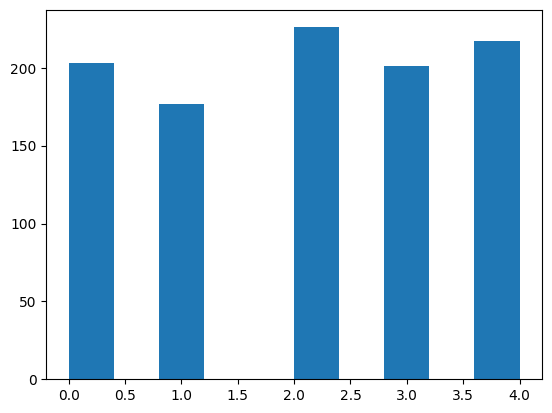

In [18]:
val_class_counts = [i.numpy() for i in val_ds_unbatched[1]]
plt.hist(val_class_counts)

In [19]:
class_names = train_ds.class_names
print(class_names)

['blue', 'flawless', 'pressed', 'stained', 'straw']


In [20]:
train_ds_unbatched = get_images_from_dataset(train_ds)
len(train_ds_unbatched[1])

3512

(array([713.,   0., 719.,   0.,   0., 676.,   0., 703.,   0., 701.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

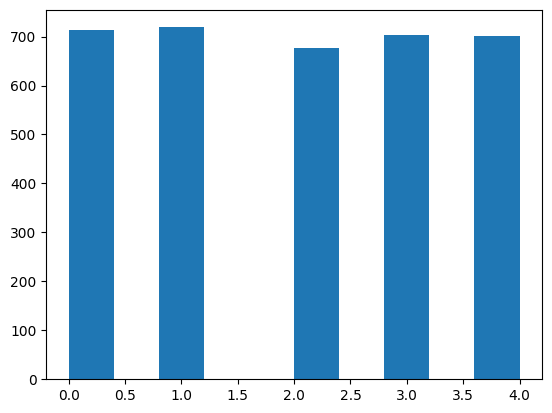

In [21]:
train_class_counts = [i.numpy() for i in train_ds_unbatched[1]]
plt.hist(train_class_counts)

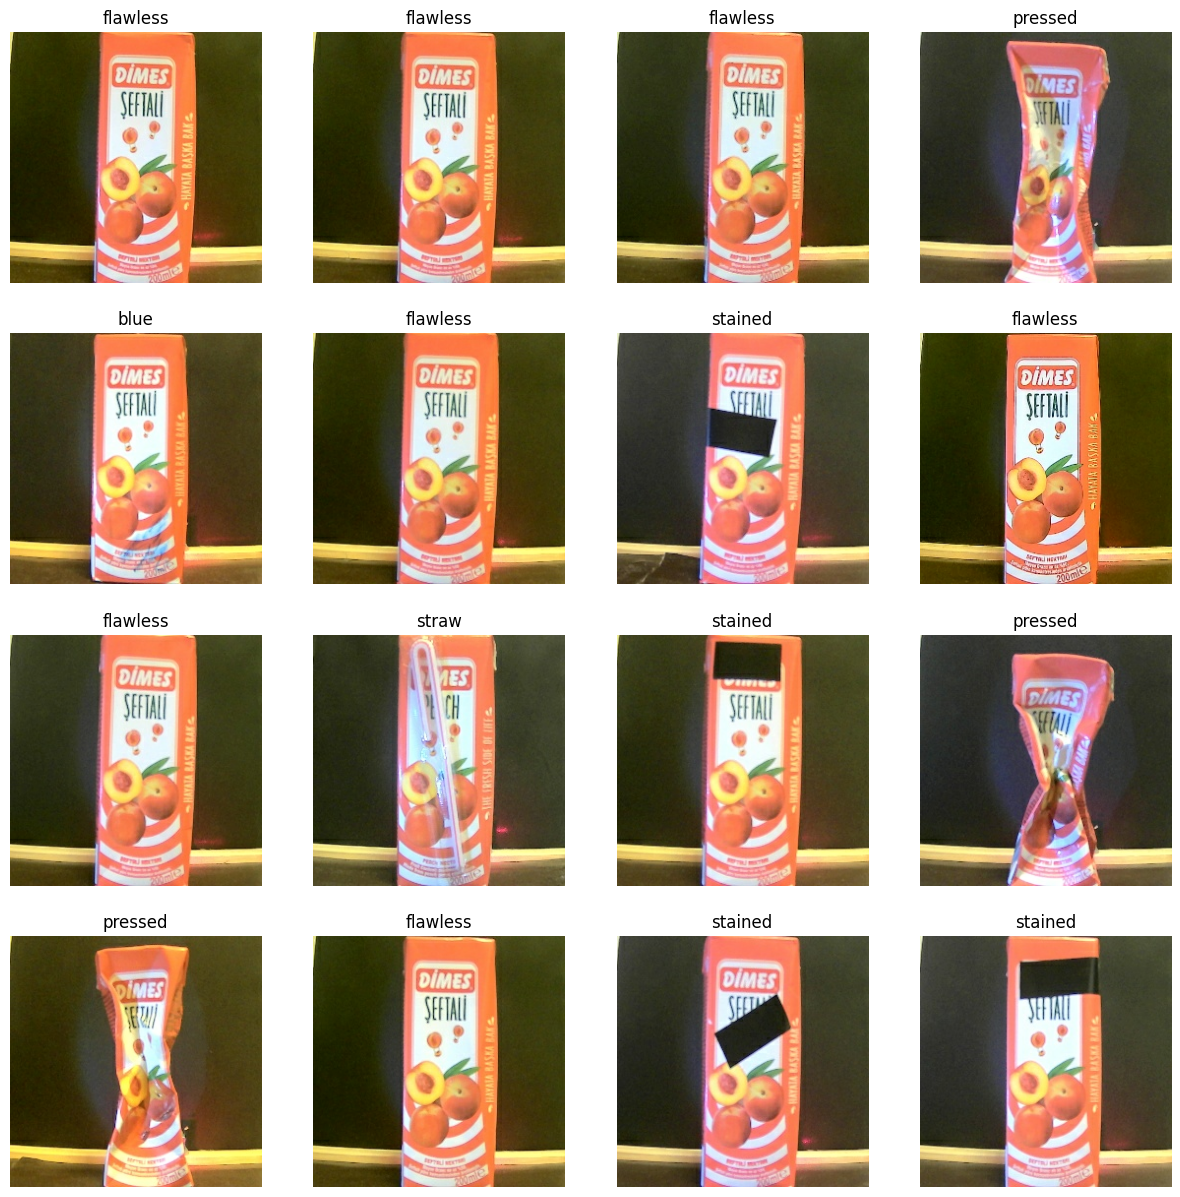

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint16"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
def get_dataset_shapes(dataset):
    for image_batch, labels_batch in dataset:
        print(image_batch.shape)
        print(labels_batch.shape)
        break

In [27]:
get_dataset_shapes(train_ds)
print('--------------')
get_dataset_shapes(val_ds)

(256, 256, 256, 3)
(256,)
--------------
(256, 256, 256, 3)
(256,)


In [28]:
normalization_layer = layers.Rescaling(1./255)      #Normalizing the values to fit it between 0 to 1, the image dataset is 8-bit RGB

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # Notice the pixel values are now in `[0,1]`.

0.0 1.0


In [29]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [35]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [38]:
# with tf.device('/CPU:0'): #Using CPU LMAO
epochs=7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/7
14/14 [==============================] - 4s 221ms/step - loss: 5.7816e-05 - accuracy: 1.0000 - val_loss: 6.0113e-05 - val_accuracy: 1.0000
Epoch 2/7
14/14 [==============================] - 4s 222ms/step - loss: 5.0486e-05 - accuracy: 1.0000 - val_loss: 6.3063e-05 - val_accuracy: 1.0000
Epoch 3/7
14/14 [==============================] - 4s 235ms/step - loss: 4.4625e-05 - accuracy: 1.0000 - val_loss: 5.3137e-05 - val_accuracy: 1.0000
Epoch 4/7
14/14 [==============================] - 3s 209ms/step - loss: 3.9501e-05 - accuracy: 1.0000 - val_loss: 5.1468e-05 - val_accuracy: 1.0000
Epoch 5/7
14/14 [==============================] - 3s 222ms/step - loss: 3.4619e-05 - accuracy: 1.0000 - val_loss: 5.1148e-05 - val_accuracy: 1.0000
Epoch 6/7
14/14 [==============================] - 3s 213ms/step - loss: 3.0377e-05 - accuracy: 1.0000 - val_loss: 3.5141e-05 - val_accuracy: 1.0000
Epoch 7/7
14/14 [==============================] - 3s 221ms/step - loss: 2.7066e-05 - accuracy: 1.0000 - v

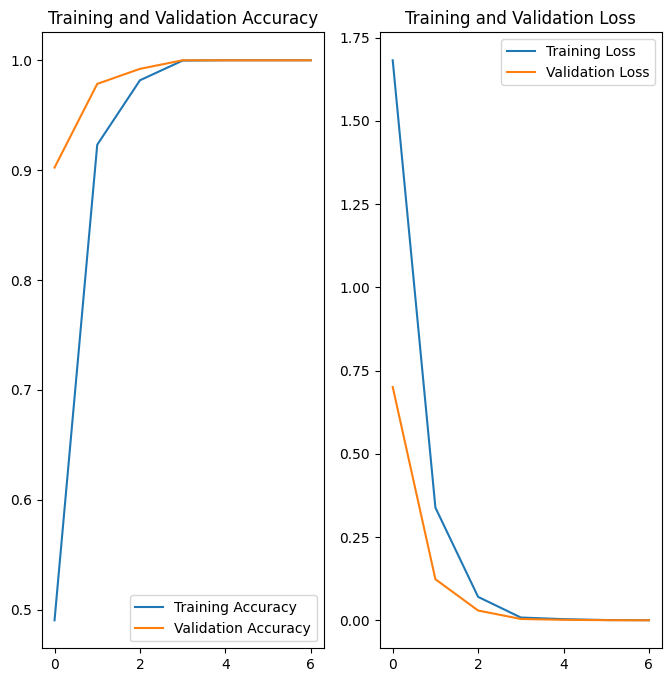

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [31]:
for images, labels in test_ds.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [32]:
numpy_images.shape

(256, 256, 256, 3)

(array([44.,  0., 47.,  0.,  0., 54.,  0., 54.,  0., 57.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

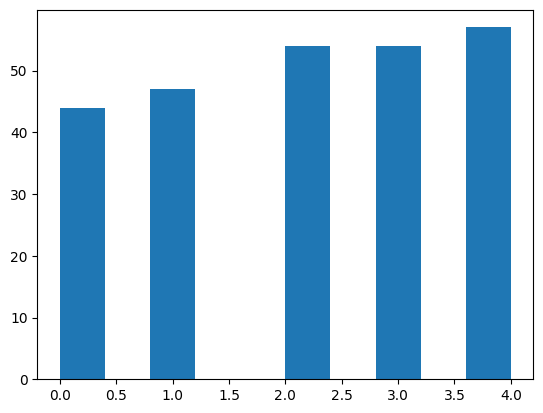

In [33]:
plt.hist(numpy_labels)

In [34]:
preds = [np.argmax(i) for i in model.predict(numpy_images)]
preds

8/8 [==============================] - 1s 11ms/step


[1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 1,
 4,
 1,
 4,
 0,
 1,
 3,
 3,
 1,
 0,
 4,
 0,
 4,
 4,
 2,
 0,
 4,
 4,
 0,
 4,
 2,
 0,
 2,
 4,
 3,
 2,
 4,
 2,
 1,
 4,
 0,
 4,
 2,
 2,
 4,
 1,
 2,
 3,
 1,
 0,
 2,
 3,
 3,
 2,
 3,
 4,
 3,
 3,
 4,
 0,
 0,
 0,
 3,
 2,
 0,
 0,
 3,
 3,
 1,
 4,
 3,
 1,
 3,
 4,
 0,
 0,
 4,
 4,
 4,
 2,
 4,
 3,
 3,
 3,
 1,
 4,
 2,
 4,
 2,
 3,
 2,
 1,
 3,
 3,
 1,
 0,
 3,
 3,
 1,
 0,
 0,
 4,
 3,
 1,
 1,
 3,
 4,
 1,
 2,
 4,
 4,
 1,
 3,
 0,
 2,
 0,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 3,
 3,
 0,
 1,
 2,
 4,
 2,
 2,
 4,
 3,
 0,
 4,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 2,
 3,
 4,
 4,
 0,
 4,
 1,
 0,
 4,
 2,
 1,
 2,
 3,
 2,
 4,
 2,
 0,
 0,
 0,
 3,
 3,
 1,
 4,
 4,
 1,
 4,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 4,
 4,
 4,
 0,
 3,
 4,
 2,
 4,
 2,
 1,
 3,
 2,
 0,
 1,
 4,
 2,
 2,
 0,
 4,
 1,
 3,
 1,
 3,
 1,
 2,
 1,
 4,
 0,
 2,
 3,
 4,
 0,
 2,
 2,
 2,
 3,
 2,
 3,
 4,
 0,
 2,
 4,
 4,
 3,
 1,
 1,
 2,
 1,
 3,
 4,
 1,
 4,
 0,
 3,
 4,
 2,
 2,
 2,
 3,
 2,
 4,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 4,
 0,
 1,
 3,
 4,


In [35]:
preds - numpy_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [37]:
from sklearn.metrics import classification_report
print(classification_report(preds,numpy_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        54
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00        57

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256

